# Data Exploration

## Overview
This notebook performs data exploration and preprocessing for ground station data from Uniandes (Universidad de los Andes). The workflow includes data loading, quality control, temporal alignment, and clear-sky modeling.

## Key Operations:

- CSV file reading and parsing
- Temporal alignment to 10-minute uniform UTC grid
- Basic Quality Control (QC) for GHI (Global Horizontal Irradiance)
- Negative value removal
- Physical ceiling clipping (1400 W/m²)
- Optional smoothing (Savitzky-Golay or moving average)
- Clear-sky modeling using pvlib and k_ghi (clear-sky index)
- Export of compressed Parquet files and diagnostic plots

## Libraries and Dependencies

In [2]:
# Core libraries
from __future__ import annotations  # Future compatibility
import os
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm import tqdm  # Progress bars

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Signal processing
from scipy.signal import savgol_filter  # Savitzky-Golay smoothing

# Solar energy modeling
import pvlib  # Photovoltaic system modeling

## Data Source

In [3]:
df = pd.read_csv("../data/datos_uniandes/datos_tierra.csv",
                          sep=";",
                          index_col=0,
                          parse_dates=True,
                          decimal=",")

## Preprocessing

- CSV Loading:
   - Semicolon-separated format
   - Index-based datetime parsing
   - Comma decimal separator handling
- Timezone Management:
   - Localize to "America/Bogota" if no timezone present
   - Convert to UTC for consistency
- Column Renaming: Simplified verbose original names to concise identifiers:
   - Humidity → "Hr"
   - Pressure → "p_hpa"
   - Wind direction → "wdir_deg"
   - Radiation → "ghi"
   - Temperature → "temp_c"
   - Wind speed → "wspd_ms"

In [4]:
if df.index.tz is None:
    df.index = df.index.tz_localize("America/Bogota")
else:
    df.index = df.index.tz_convert("America/Bogota")
df = df.tz_convert("UTC")

# Normaliza nombres de columnas (más cortos y claros)
rename_map = {
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Humedad relativa del aire 1 [%] - E_AH_REL1": "Hr",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Presión relativa del aire 1 [hPa] - E_AP_REL1": "p_hpa",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Dirección del viento [°] - E_W_D": "wdir_deg",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Radiación [W/m²] - SRAD": "ghi",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Temperatura [°C] - T": "temp_c",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Velocidad del viento [m/s] - E_W_S": "wspd_ms",
}
df = df.rename(columns=rename_map).sort_index()

print(df.shape)
df.head()

(165312, 6)


,Hr,p_hpa,wdir_deg,ghi,temp_c,wspd_ms
Timestamp,,,,,,
2023-09-01 05:00:00+00:00,73.896,745.288,163.000,0.000,12.718,1.042
2023-09-01 05:05:00+00:00,74.888,745.184,108.532,0.000,12.292,2.858
2023-09-01 05:10:00+00:00,76.484,745.140,113.694,0.000,11.932,2.728
2023-09-01 05:15:00+00:00,76.674,745.032,110.576,0.144,12.132,2.300
2023-09-01 05:20:00+00:00,75.824,744.972,116.006,0.000,12.318,1.346


### Data Quality Assessment
- Temporal Range: Shows minimum and maximum timestamps
- Statistical Summary: Provides percentiles (1%, 5%, 50%, 95%, 99%) for data validation
- Null Analysis: Calculates percentage of missing values per variable
- Daily Coverage: Resamples data availability on daily basis

In [5]:
print("Rango temporal:", df.index.min(), "→", df.index.max())
print("\nDescripción (percentiles útiles):")
display(df.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T)


nulls_pct = df.isna().mean().sort_values(ascending=False)*100
print("\n% nulos por variable:")
display(nulls_pct.to_frame("pct_nulls"))

cov_daily = df.notna().resample("D").mean()*100
cov_daily.tail()

Rango temporal: 2023-09-01 05:00:00+00:00 → 2025-03-28 04:55:00+00:00

Descripción (percentiles útiles):


,count,mean,std,min,1%,5%,50%,95%,99%,max
Hr,165147.0,71.699712,14.406764,15.272,35.26892,45.7746,73.878,91.9460,95.18400,99.804
p_hpa,165147.0,743.014925,1.314290,738.602,739.95892,740.7600,743.068,745.0520,745.67708,747.360
wdir_deg,165147.0,135.232888,48.982062,0.000,50.07320,79.9026,119.550,242.7708,284.26080,342.806
ghi,165147.0,173.209745,275.741277,0.000,0.00000,0.0000,1.960,833.5880,1083.02880,1448.416
temp_c,165147.0,15.756548,3.197444,7.302,10.02800,11.3000,15.176,21.5360,23.39800,27.272
wspd_ms,165147.0,1.732127,1.362863,0.000,0.16400,0.3000,1.248,4.3180,5.74800,14.474



% nulos por variable:


,pct_nulls
Hr,0.099811
p_hpa,0.099811
wdir_deg,0.099811
ghi,0.099811
temp_c,0.099811
wspd_ms,0.099811


,Hr,p_hpa,wdir_deg,ghi,temp_c,wspd_ms
Timestamp,,,,,,
2025-03-24 00:00:00+00:00,100.0,100.0,100.0,100.0,100.0,100.0
2025-03-25 00:00:00+00:00,100.0,100.0,100.0,100.0,100.0,100.0
2025-03-26 00:00:00+00:00,100.0,100.0,100.0,100.0,100.0,100.0
2025-03-27 00:00:00+00:00,100.0,100.0,100.0,100.0,100.0,100.0
2025-03-28 00:00:00+00:00,100.0,100.0,100.0,100.0,100.0,100.0


### Temporal Resampling and Quality Control
- Resampling: 10-minute intervals using mean aggregation
-GHI Quality Control:

    - Clips negative values to 0

    - Caps maximum values at 1400 W/m² (physical limit)

In [6]:
FREQ = "10min"
df10 = df.resample(FREQ).mean()

if "ghi" in df10.columns:
    df10["ghi_qc"] = df10["ghi"].clip(lower=0, upper=1400)
else:
    raise KeyError("No se encontró la columna 'ghi' tras el renombrado.")

print(df10[["ghi", "ghi_qc"]].head())

                             ghi  ghi_qc
Timestamp                               
2023-09-01 05:00:00+00:00  0.000   0.000
2023-09-01 05:10:00+00:00  0.072   0.072
2023-09-01 05:20:00+00:00  0.000   0.000
2023-09-01 05:30:00+00:00  0.000   0.000
2023-09-01 05:40:00+00:00  0.000   0.000


## Gráphics

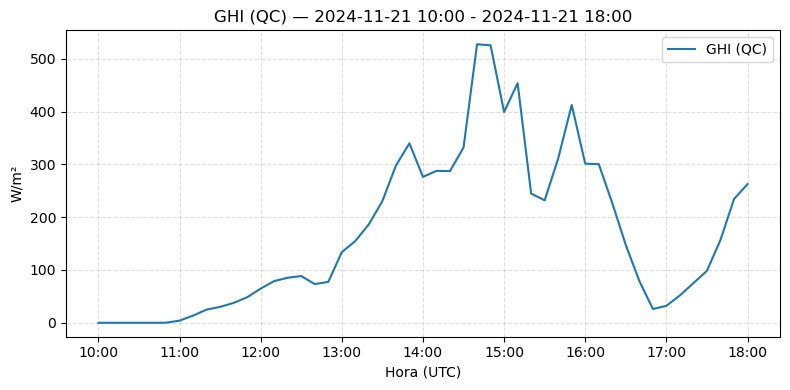

In [7]:
ini, fin = "2024-11-21 10:00", "2024-11-21 18:00"

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df10.loc[ini:fin, "ghi_qc"], label="GHI (QC)")
ax.set_title(f"GHI (QC) — {ini} - {fin}")
ax.set_xlabel("Hora (UTC)"); ax.set_ylabel("W/m²")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid(True, linestyle="--", alpha=0.4); ax.legend(); fig.tight_layout()
plt.show()

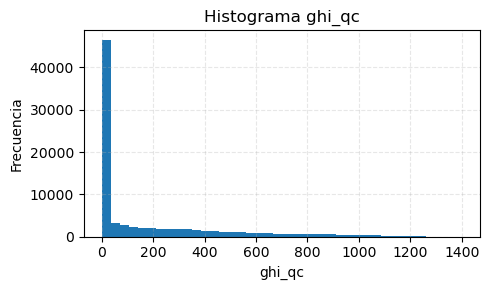

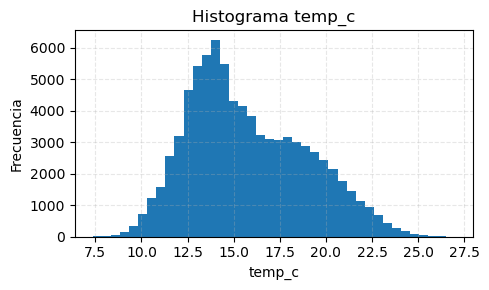

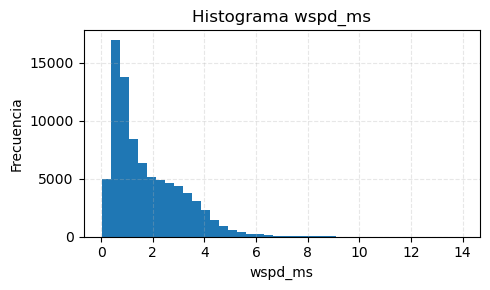

In [8]:
vars_hist = ["ghi_qc", "temp_c", "wspd_ms", "rh"]
for v in [c for c in vars_hist if c in df10.columns]:
    plt.figure(figsize=(5,3))
    df10[v].dropna().plot(kind="hist", bins=40)
    plt.title(f"Histograma {v}")
    plt.xlabel(v); plt.ylabel("Frecuencia")
    plt.grid(True, linestyle="--", alpha=0.3); plt.tight_layout()
    plt.show()

## Smoothing (Savitzky–Golay vs Moving Average)

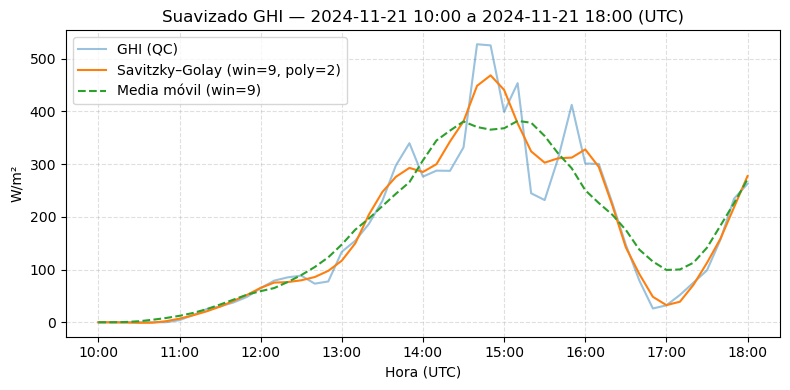

In [9]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Parámetros (10 min de muestreo → 9 muestras ≈ 90 min)
SG_WINDOW = 9      # debe ser impar y >= 3
SG_POLY   = 2      # orden del polinomio (1–3 suele bastar)
ROLL_WIN  = 9      # media móvil para comparar (misma ventana)

# Validaciones suaves
n = df10.shape[0]
if SG_WINDOW % 2 == 0:
    SG_WINDOW += 1
if SG_WINDOW > n:
    SG_WINDOW = max(3, (n // 2) * 2 + 1)  # impar <= n

# Interpola huecos cortos para estabilizar el filtro
y = df10["ghi_qc"].to_numpy(dtype="float64")
mask = np.isfinite(y)
y_interp = pd.Series(y).interpolate(limit_direction="both").to_numpy()

# Savitzky–Golay (centrado, NO causal)
y_sg = savgol_filter(y_interp, window_length=SG_WINDOW, polyorder=SG_POLY)
y_sg[~mask] = np.nan
df10["ghi_sg"] = y_sg

# Media móvil centrada (para comparar)
df10["ghi_roll"] = df10["ghi_qc"].rolling(ROLL_WIN, center=True, min_periods=1).mean()

# Plot comparativo en la misma ventana
ini, fin = "2024-11-21 10:00", "2024-11-21 18:00"
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df10.loc[ini:fin, "ghi_qc"],   label="GHI (QC)", alpha=0.45)
ax.plot(df10.loc[ini:fin, "ghi_sg"],   label=f"Savitzky–Golay (win={SG_WINDOW}, poly={SG_POLY})")
ax.plot(df10.loc[ini:fin, "ghi_roll"], label=f"Media móvil (win={ROLL_WIN})", linestyle="--")

ax.set_title(f"Suavizado GHI — {ini} a {fin} (UTC)")
ax.set_xlabel("Hora (UTC)"); ax.set_ylabel("W/m²")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid(True, linestyle="--", alpha=0.4); ax.legend(); fig.tight_layout()
plt.show()